### Clustering

You will be performing kmeans clustering on the same product reviews dataset from Part 1. In this question, instead of statistically computing features, you will use the embeddings obtained from a neural sentiment analysis model (huggingface: siebert/sentiment-roberta-large-english).

You can use sklearn for this question. Your tasks are as follows:


1. Perform kmeans clustering using sklearn. Try various values for number of clusters (k) and plot the elbow curve. For each value of k, plot WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.
1. Perform task 1 with cluster initialisation methods [k-means++, forgy ("random" in sklearn)].
1. In this case, since the ground truth labels (star rating) are available we can evaluate the clustering using metrics like purity, nmi and rand score. Implement these metrics from scratch and evaluate the clustering. [Reference](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

In [ ]:
import gzip
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.spatial.distance import cdist

In [ ]:
f = gzip.GzipFile('/content/drive/MyDrive/SMAI FOLDERS Assignment 2/Copy of roberta_embeds.npy.gz', "r")
embeds = np.load(f)
print(embeds.shape)

(26661, 1024)


In [ ]:
def calculate_wcss(data, kmeans):
    wcss = sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
    return wcss

In [ ]:
def compute_purity(y_true, y_pred):
    contingency_matrix = {}
    for true, pred in zip(y_true, y_pred):
        if pred not in contingency_matrix:
            contingency_matrix[pred] = {}
        if true not in contingency_matrix[pred]:
            contingency_matrix[pred][true] = 0
        contingency_matrix[pred][true] += 1

    # Compute purity
    total = sum(sum(values.values()) for values in contingency_matrix.values())
    purity = sum(max(values.values()) for values in contingency_matrix.values()) / total
    return purity


In [ ]:
import numpy as np

def compute_entropy(labels):
    _, label_counts = np.unique(labels, return_counts=True)
    probabilities = label_counts / label_counts.sum()
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

def compute_mutual_information(y_true, y_pred):
    total = len(y_true)
    true_labels, pred_labels = np.unique(y_true), np.unique(y_pred)
    mi = 0
    for true_label in true_labels:
        for pred_label in pred_labels:
            intersection = np.logical_and(y_true == true_label, y_pred == pred_label).sum()
            if intersection > 0:
                p_true = np.sum(y_true == true_label) / total
                p_pred = np.sum(y_pred == pred_label) / total
                p_joint = intersection / total
                mi += p_joint * np.log(p_joint / (p_true * p_pred))
    return mi

def compute_nmi(y_true, y_pred):
    # Mutual information is used to assess the quality of clustering by evaluating how much information about the true labels is gained by observing the cluster assignments
    mi = compute_mutual_information(y_true, y_pred)
    entropy_true = compute_entropy(y_true)
    entropy_pred = compute_entropy(y_pred)
    nmi = mi / np.sqrt(entropy_true * entropy_pred)
    return nmi

In [ ]:
def compute_rand_index(y_true, y_pred):
    # how well the clustering matches the true labels, independent of the absolute label values
    from itertools import combinations
    pairs = list(combinations(range(len(y_true)), 2))
    tp_plus_fp = sum(1 for i, j in pairs if y_pred[i] == y_pred[j])
    tp_plus_fn = sum(1 for i, j in pairs if y_true[i] == y_true[j])
    tp = sum(1 for i, j in pairs if y_pred[i] == y_pred[j] and y_true[i] == y_true[j])
    total_pairs = len(pairs)
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = total_pairs - tp - fp - fn
    ri = (tp + tn) / total_pairs
    return ri


In [ ]:
wcss = []
labels_kmeanspp = {}

ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(embeds)
    wcss.append(kmeans.inertia_)
    labels_kmeanspp[k] = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.plot(ks, wcss, '-o')
plt.title('Elbow Curve using k-means++ initialization')
plt.xlabel('Number of clusters, k')
plt.ylabel('WCSS')
plt.xticks(ks)
plt.show()

plt.tight_layout()
plt.show()

print(labels_kmeanspp)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{4: array([1, 2, 1, ..., 2, 2, 2], dtype=int32)}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

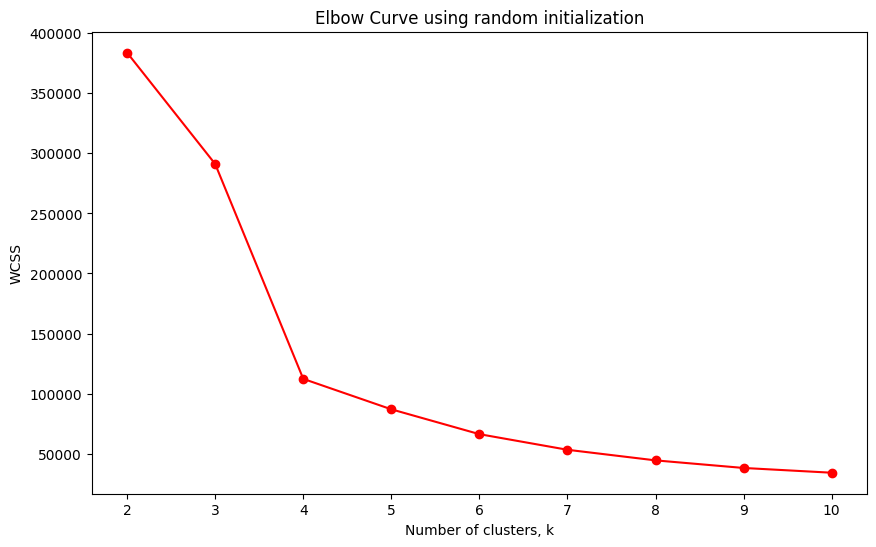

{2: array([1, 0, 1, ..., 0, 0, 0], dtype=int32), 3: array([1, 0, 1, ..., 0, 0, 0], dtype=int32), 4: array([3, 1, 3, ..., 1, 1, 1], dtype=int32), 5: array([4, 2, 4, ..., 2, 2, 2], dtype=int32), 6: array([1, 5, 1, ..., 5, 5, 5], dtype=int32), 7: array([6, 5, 6, ..., 3, 5, 5], dtype=int32), 8: array([7, 5, 7, ..., 3, 5, 5], dtype=int32), 9: array([7, 8, 7, ..., 5, 8, 8], dtype=int32), 10: array([7, 8, 7, ..., 5, 8, 8], dtype=int32)}


In [ ]:
wcss_random = []
labels_random = {}

for k in ks:
    kmeans_random = KMeans(n_clusters=k, init='random', random_state=42).fit(embeds)
    wcss_random.append(kmeans_random.inertia_)
    labels_random[k] = kmeans_random.labels_

plt.figure(figsize=(10, 6))
plt.plot(ks, wcss_random, '-o', color='red')
plt.title('Elbow Curve using random initialization')
plt.xlabel('Number of clusters, k')
plt.ylabel('WCSS')
plt.xticks(ks)
plt.show()

print(labels_random)

In [ ]:
print("Kmeans++\n")

purity = compute_purity(data['stars'], labels_kmeanspp[4])
nmi = normalized_mutual_info_score(data['stars'], labels_kmeanspp[4])
ri = adjusted_rand_score(data['stars'], labels_kmeanspp[4])

print(f"Purity: {purity:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Rand Index (RI): {ri:.4f}")

Kmeans++

Purity: 0.7132
Normalized Mutual Information (NMI): 0.5200
Rand Index (RI): 0.4815


In [ ]:
print("Random initialisation\n")

purity = compute_purity(data['stars'], labels_random[4])
nmi = normalized_mutual_info_score(data['stars'], labels_random[4])
ri = adjusted_rand_score(data['stars'], labels_random[4])

print(f"Purity: {purity:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Rand Index (RI): {ri:.4f}")

Random initialisation

Purity: 0.7132
Normalized Mutual Information (NMI): 0.5200
Rand Index (RI): 0.4815
